In [1]:
import numpy as np
from 
from keras.models import Model
from keras.layers.convolutional import Convolution2D
from keras.layers.core import Dense, Reshape, Dropout, Activation
from keras.layers import Input, BatchNormalization
from keras.losses import mean_squared_error, categorical_crossentropy
from keras.optimizers import Adam
from keras.utils import plot_model

from utils import LossHistory, plotHistory, visualization_train, visualization_data, rotation_accuracy
from keras_capsnet.layer.capsnet import PrimaryCaps, Caps, ClassesCaps, Mask
from keras_capsnet.losses import margin
from keras_capsnet.activations import squash
from datasets.mnist import dataGenerator

Using TensorFlow backend.


# Parameters

In [2]:
num_class = 10
input_shape = (28, 28, 1)
m_train = 60000
m_test = 50000

batch_size = 32

data_augmentation = {
    'width_shift_range': 2,
    'height_shift_range': 2
}

# Dataset

In [3]:
trainGenerator = dataGenerator('train', batch_size=batch_size, **data_augmentation)
testGenerator = dataGenerator('test', batch_size=batch_size)

# Model

In [4]:
x = Input(shape=input_shape)
y = Input(shape=(num_class,))

encoder = Convolution2D(filters=80, kernel_size=(9, 9), activation='relu') (x)
encoder = PrimaryCaps(capsules=8, capsule_dim=6, kernel_size=(9, 9), strides=2, activation='relu', activation_caps=squash) (encoder)
encoder = Caps(capsules=10, capsule_dim=10, routings=3, activation_caps=squash) (encoder)

output = ClassesCaps(name='capsule') (encoder)

decoder = Mask() (encoder, y_true=y)
decoder = Dense(512, activation='relu') (decoder)
decoder = Dense(1024, activation='relu') (decoder)
decoder = Dense(784, activation='sigmoid') (decoder)
decoder = Reshape((input_shape), name='reconstruction') (decoder)

model_training = Model(inputs=[x, y], outputs=[output, decoder])
model = Model(inputs=x, outputs=output)

In [5]:
plot_model(model, to_file="images/capsule_archi.png", show_shapes=True)
plot_model(model_training, to_file="images/training_archi.png", show_shapes=True)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 20, 20, 80)        6560      
_________________________________________________________________
primary_caps_1 (PrimaryCaps) (None, 288, 6)            311088    
_________________________________________________________________
caps_1 (Caps)                (None, 10, 10)            172800    
_________________________________________________________________
capsule (ClassesCaps)        (None, 10)                0         
Total params: 490,448
Trainable params: 490,448
Non-trainable params: 0
_________________________________________________________________


# Training

In [6]:
model_training.compile(optimizer=Adam(lr=1e-3),
                       loss=[margin(), mean_squared_error],
                       loss_weights=[1, 0.0005],
                       metrics={'capsule': 'accuracy'})

model.compile(optimizer=Adam(), loss=margin(), metrics=['accuracy'])

In [7]:
history = LossHistory(metrics=('loss', 'capsule_loss', 'reconstruction_loss', 'capsule_acc'))

Epoch 1/20
 - 138s - loss: 0.0651 - capsule_loss: 0.0651 - reconstruction_loss: 0.0834 - capsule_acc: 0.9344 - val_loss: 0.0159 - val_capsule_loss: 0.0159 - val_reconstruction_loss: 0.0565 - val_capsule_acc: 0.9885
Epoch 2/20
 - 136s - loss: 0.0174 - capsule_loss: 0.0173 - reconstruction_loss: 0.0581 - capsule_acc: 0.9857 - val_loss: 0.0103 - val_capsule_loss: 0.0103 - val_reconstruction_loss: 0.0534 - val_capsule_acc: 0.9913
Epoch 3/20
 - 136s - loss: 0.0131 - capsule_loss: 0.0131 - reconstruction_loss: 0.0575 - capsule_acc: 0.9893 - val_loss: 0.0098 - val_capsule_loss: 0.0098 - val_reconstruction_loss: 0.0533 - val_capsule_acc: 0.9926
Epoch 4/20
 - 135s - loss: 0.0111 - capsule_loss: 0.0110 - reconstruction_loss: 0.0574 - capsule_acc: 0.9910 - val_loss: 0.0100 - val_capsule_loss: 0.0100 - val_reconstruction_loss: 0.0533 - val_capsule_acc: 0.9925
Epoch 5/20
 - 135s - loss: 0.0096 - capsule_loss: 0.0095 - reconstruction_loss: 0.0573 - capsule_acc: 0.9923 - val_loss: 0.0079 - val_capsul

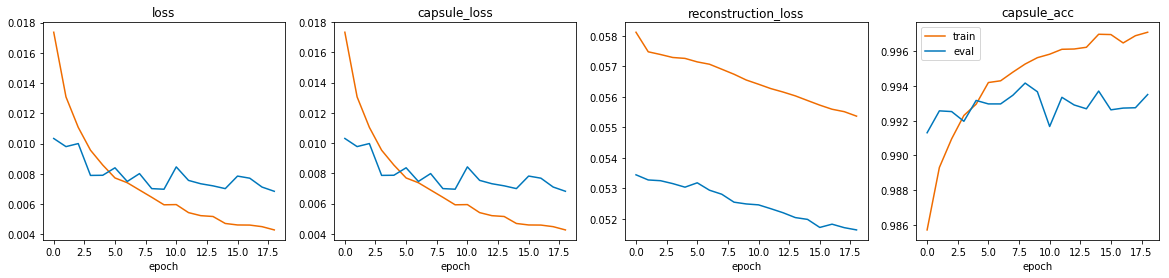

In [8]:
hist = model_training.fit_generator(trainGenerator,
                                    steps_per_epoch=m_train // batch_size,
                                    epochs=20,
                                    validation_data=testGenerator,
                                    validation_steps=m_test // batch_size,
                                    verbose=2,
                                    callbacks=[history])
plotHistory(history.metrics)

# Training visualization

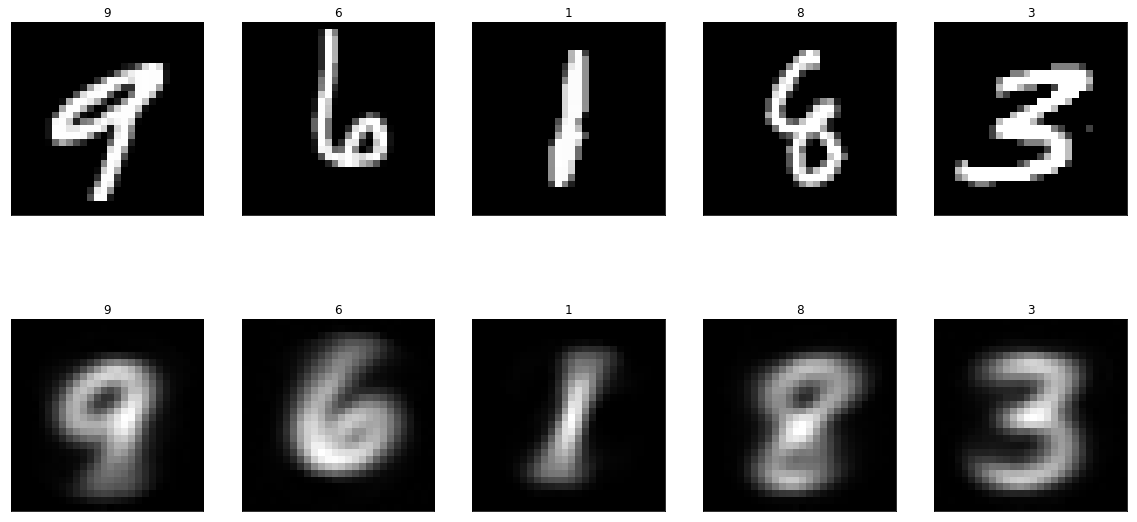

In [10]:
n_image = 5

# Select data
images, labels = next(dataGenerator('test', batch_size=n_image, reshape=False))

# Run inference
classes, reconstructions = model_training.predict([images, labels])

# Post-process data
labels = np.argmax(labels, axis=1)
predictions = np.argmax(classes, axis=1)
images = images.reshape(-1, 28, 28)
reconstructions = reconstructions.reshape(-1, 28, 28)

visualization_train((images, labels), (reconstructions, predictions))

# Evaluation on augmented data

## Accuracy
Test accuracy for different rotations on test data

Test acc [0.0°]:	0.993
Test acc [20.0°]:	0.984
Test acc [40.0°]:	0.911
Test acc [60.0°]:	0.759
Test acc [80.0°]:	0.626
Test acc [100.0°]:	0.54
Test acc [120.0°]:	0.483
Test acc [140.0°]:	0.456
Test acc [160.0°]:	0.451
Test acc [180.0°]:	0.447


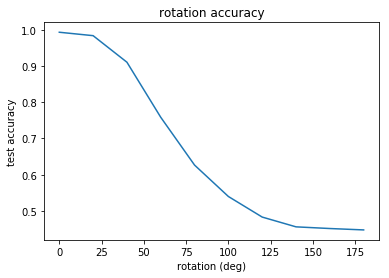

In [12]:
rotation_accuracy(model, dataGenerator, m_test=m_test, batch_size=batch_size)

## Visualization

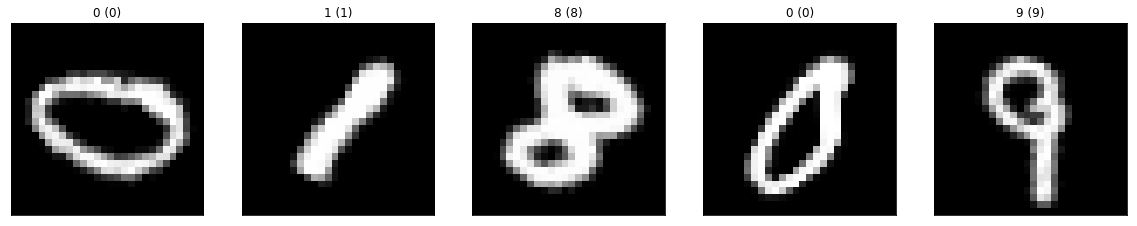

In [13]:
n_image=5
data_augmentation = {'rotation_range': 50}

# Select data
testGenerator = dataGenerator('test', batch_size=n_image, reshape=False, **data_augmentation)
images, labels = next(testGenerator)

# Run inference
predictions = model.predict(images)

# Post-process data
labels = np.argmax(labels, axis=1)
predictions = np.argmax(predictions, axis=1)
images = images.reshape((-1, 28, 28))

visualization_data(images, labels, predictions)